In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [137]:
df = pd.read_pickle(r"C:\Users\dpine\red_electrica\red_electrica\data\df_definitivo.pickle")


--- Resultados Finales ---
MAE Test: 472.81
RMSE Test: 665.88


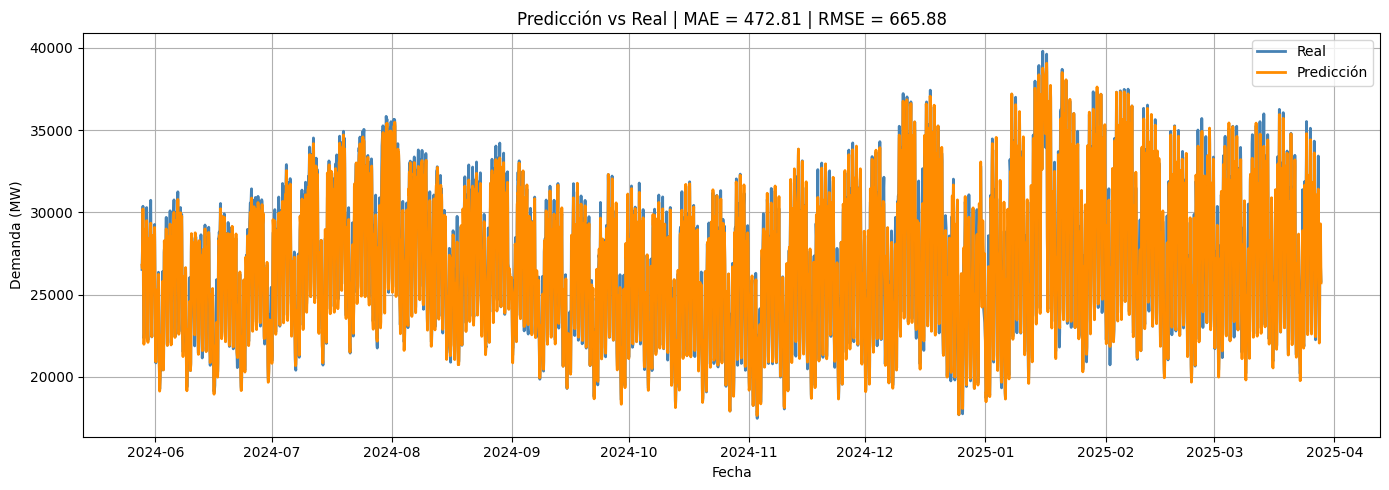

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Cargar datos ---
df = df.sort_values("date").set_index("date")
df = df.select_dtypes(include=[np.number])  # Solo columnas numéricas

# --- Separar en train/test: últimos 10 meses ---
fecha_corte = df.index.max() - pd.DateOffset(months=10)
df_train = df[df.index < fecha_corte]
df_test = df[df.index >= fecha_corte]

# --- Features y target ---
X_train = df_train.drop(columns=["value"]).to_numpy(dtype=np.float32)
y_train = df_train["value"].to_numpy(dtype=np.float32)

X_test = df_test.drop(columns=["value"]).to_numpy(dtype=np.float32)
y_test = df_test.filter(like='value', axis=1)  # <- por si hay duplicadas
y_test_real = y_test.iloc[:, 0]  # <- nos quedamos con la buena

# --- Entrenar modelo ---
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- Si por algún motivo y_pred tiene más de una columna ---
if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
    y_pred = y_pred[:, 0]  # nos quedamos solo con la primera

# --- Métricas ---
mae = mean_absolute_error(y_test_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))

print(f"\n--- Resultados Finales ---")
print(f"MAE Test: {mae:.2f}")
print(f"RMSE Test: {rmse:.2f}")

# --- Gráfico profesional limpio ---
plt.figure(figsize=(14, 5))
plt.plot(df_test.index, y_test_real, label='Real', color='steelblue', linewidth=2)
plt.plot(df_test.index, y_pred, label='Predicción', color='darkorange', linewidth=2)
plt.title(f"Predicción vs Real | MAE = {mae:.2f} | RMSE = {rmse:.2f}")
plt.xlabel("Fecha")
plt.ylabel("Demanda (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- (Opcional) Exportar resultados
df_resultado = pd.DataFrame({
    "fecha": df_test.index,
    "real": y_test_real.values,
    "prediccion": y_pred
})
# df_resultado.to_excel("prediccion_vs_real.xlsx", index=False)  # ← descomenta si lo necesitas


Fitting 4 folds for each of 20 candidates, totalling 80 fits

Mejores parámetros encontrados:
{'subsample': 0.8, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.6}

--- Resultados Finales ---
MAE Test: 474.59
RMSE Test: 680.23


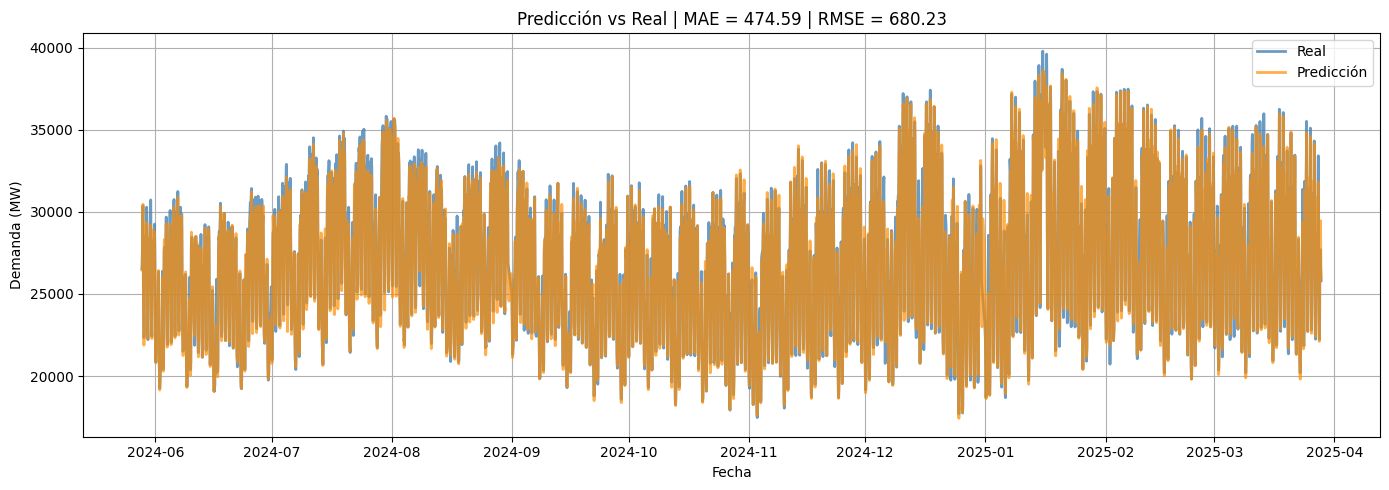

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Cargar y preparar datos ---
df = df.sort_values("date").set_index("date")
df = df.select_dtypes(include=[np.number])  # Solo columnas numéricas

target = "value"
features = df.drop(columns=[target]).columns

# --- Separar train/test (últimos 10 meses) ---
fecha_corte = df.index.max() - pd.DateOffset(months=10)
df_train = df[df.index < fecha_corte]
df_test = df[df.index >= fecha_corte]

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test.filter(like='value', axis=1).iloc[:, 0]  # <-- columna buena

# --- Conversión a float32 ---
X_train_np = X_train.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.float32)
X_test_np = X_test.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.float32)

# --- Hiperparámetros a probar ---
param_dist = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5]
}

# --- Cross-validation ---
tscv = TimeSeriesSplit(n_splits=4)
xgb_model = XGBRegressor(random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_np, y_train_np)

# --- Evaluación final ---
best_model = search.best_estimator_
print(f"\nMejores parámetros encontrados:\n{search.best_params_}")

y_pred_test = best_model.predict(X_test_np)
mae_test = mean_absolute_error(y_test_np, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test_np, y_pred_test))

print("\n--- Resultados Finales ---")
print(f"MAE Test: {mae_test:.2f}")
print(f"RMSE Test: {rmse_test:.2f}")

# --- Gráfico limpio ---
plt.figure(figsize=(14, 5))
plt.plot(df_test.index, y_test_np, label='Real', linewidth=2, alpha=0.8, color='steelblue')
plt.plot(df_test.index, y_pred_test, label='Predicción', linewidth=2, alpha=0.7, color='darkorange')
plt.title(f"Predicción vs Real | MAE = {mae_test:.2f} | RMSE = {rmse_test:.2f}")
plt.xlabel("Fecha")
plt.ylabel("Demanda (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Fitting 4 folds for each of 20 candidates, totalling 80 fits

Mejores parámetros encontrados:
{'subsample': 0.8, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.6}

--- Resultados Finales ---
MAE Test: 464.40
RMSE Test: 663.69


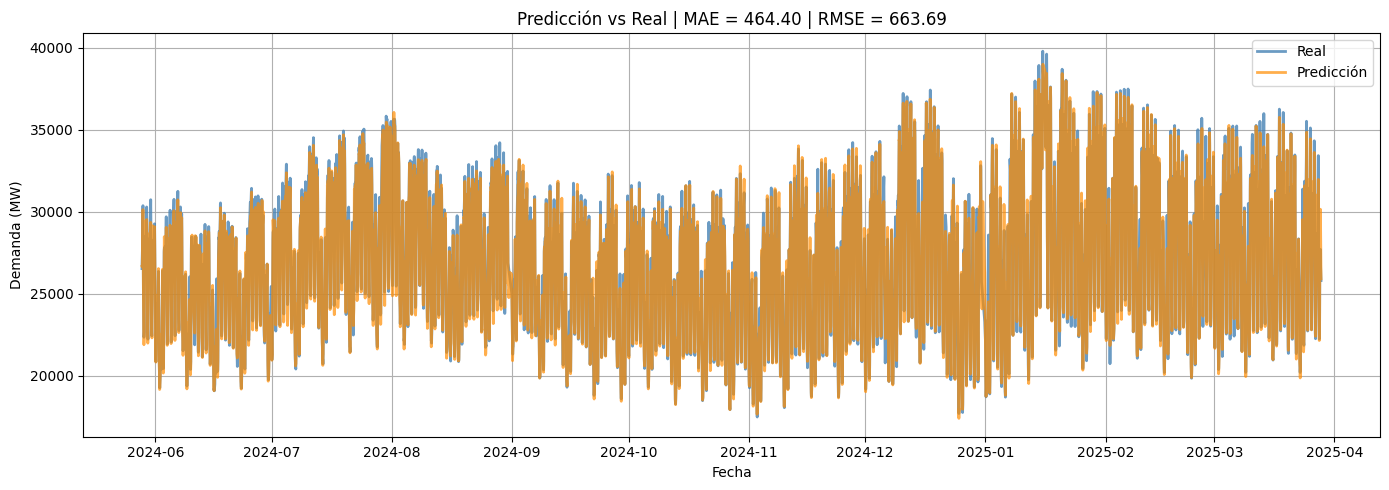

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Cargar y preparar datos ---
df = df.sort_values("date").set_index("date")
df = df.select_dtypes(include=[np.number])  # Solo columnas numéricas

target = "value"
features = df.drop(columns=[target]).columns

# --- Separar train/test (últimos 10 meses) ---
fecha_corte = df.index.max() - pd.DateOffset(months=10)
df_train = df[df.index < fecha_corte]
df_test = df[df.index >= fecha_corte]

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test.filter(like='value', axis=1).iloc[:, 0]  # <-- columna buena

# --- Conversión a float32 ---
X_train_np = X_train.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.float32)
X_test_np = X_test.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.float32)

# --- Hiperparámetros a probar ---
param_dist = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5]
}

# --- Cross-validation ---
tscv = TimeSeriesSplit(n_splits=4)
xgb_model = XGBRegressor(random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_np, y_train_np)

# --- Evaluación final ---
best_model = search.best_estimator_
print(f"\nMejores parámetros encontrados:\n{search.best_params_}")

y_pred_test = best_model.predict(X_test_np)
mae_test = mean_absolute_error(y_test_np, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test_np, y_pred_test))

print("\n--- Resultados Finales ---")
print(f"MAE Test: {mae_test:.2f}")
print(f"RMSE Test: {rmse_test:.2f}")

# --- Gráfico limpio ---
plt.figure(figsize=(14, 5))
plt.plot(df_test.index, y_test_np, label='Real', linewidth=2, alpha=0.8, color='steelblue')
plt.plot(df_test.index, y_pred_test, label='Predicción', linewidth=2, alpha=0.7, color='darkorange')
plt.title(f"Predicción vs Real | MAE = {mae_test:.2f} | RMSE = {rmse_test:.2f}")
plt.xlabel("Fecha")
plt.ylabel("Demanda (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Análisis de errores

In [139]:
errores = y_test_np - y_pred_test

In [140]:
df_errores = pd.DataFrame({
    "fecha": df_test.index,
    "error": errores,
    "real": y_test_np,
    "prediccion": y_pred_test
})

In [141]:
df_errores["dia"] = df_errores["fecha"].dt.date

In [142]:
df_error_diario = df_errores.groupby("dia")["error"].mean().reset_index()

In [143]:
import plotly.graph_objects as go

fig = go.Figure()

# Línea de error diario
fig.add_trace(go.Scatter(
    x=df_error_diario["dia"],
    y=df_error_diario["error"],
    mode="lines",
    line=dict(color="crimson", width=2),
    name="Error diario"
))

# Línea horizontal en 0
fig.add_shape(
    type="line",
    x0=df_error_diario["dia"].min(),
    x1=df_error_diario["dia"].max(),
    y0=0, y1=0,
    line=dict(color="gray", width=1, dash="dash")
)

# Layout
fig.update_layout(
    title="Error medio por día (Real - Predicción)",
    xaxis_title="Fecha",
    yaxis_title="Error medio diario",
    template="plotly_white",
    height=450,
    width=1000,
    showlegend=True
)

fig.show()

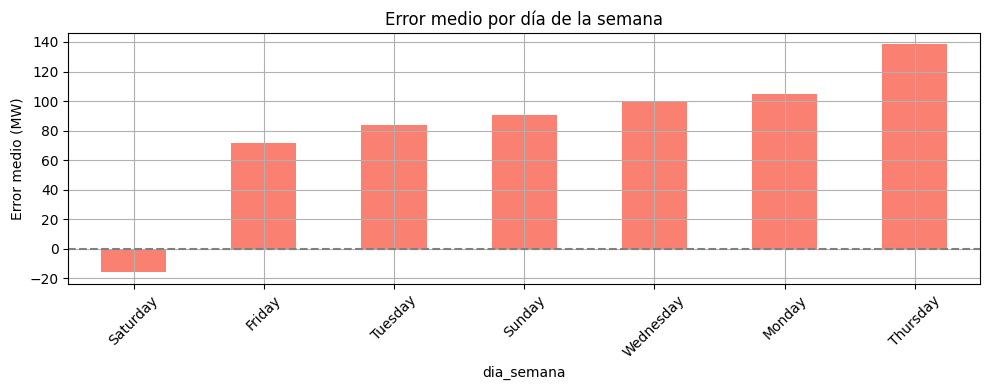

In [144]:
df_errores["dia_semana"] = df_errores["fecha"].dt.day_name()
errores_por_dia = df_errores.groupby("dia_semana")["error"].mean().sort_values()

errores_por_dia.plot(kind="bar", figsize=(10, 4), title="Error medio por día de la semana", color="salmon")
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Error medio (MW)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

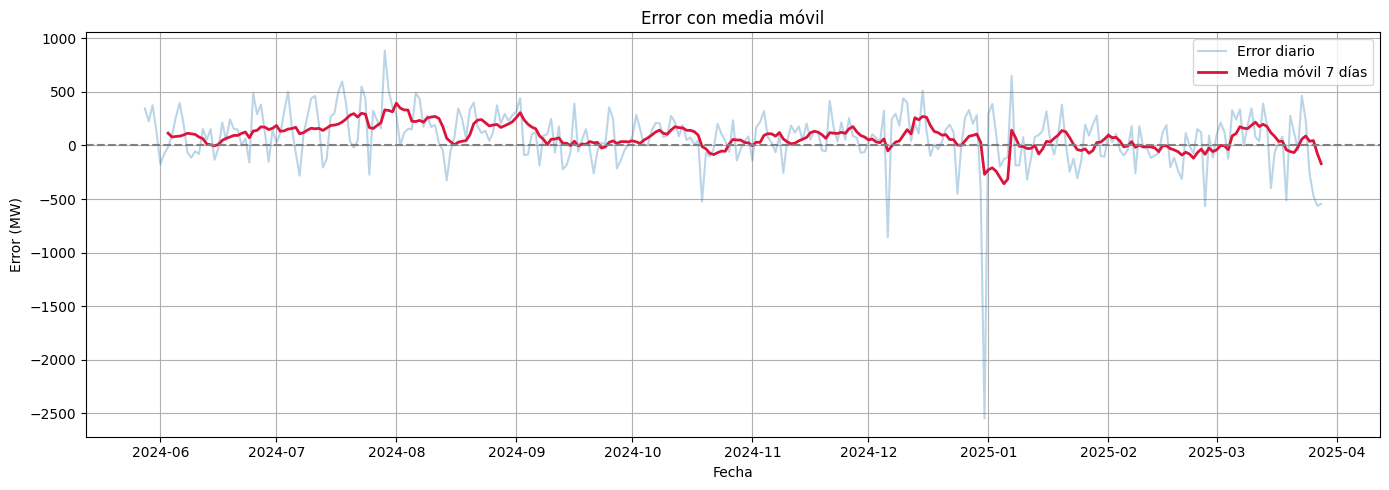

In [145]:
df_error_diario["error_ma7"] = df_error_diario["error"].rolling(7).mean()

plt.figure(figsize=(14, 5))
plt.plot(df_error_diario["dia"], df_error_diario["error"], alpha=0.3, label="Error diario")
plt.plot(df_error_diario["dia"], df_error_diario["error_ma7"], color="crimson", label="Media móvil 7 días", linewidth=2)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Error con media móvil")
plt.xlabel("Fecha")
plt.ylabel("Error (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()